# Import libraries

In [1]:
# basemodels
from models import QuantileLinearRegressor, QuantileForestRegressor, QuantileNeuralRegressor
from arima import ARIMA
import quantnn

# metrics for comparison
from metrics import Metrics

# conformal methods to use
from conformal_methods import ACI, CQR, EnbPI, EnCQR

# data generation and subplots
from utils import SyntheticData, create_subplots, \
train_val_test, split_x_y, compute_aci, optimize_conformal, plot_test_PIs

# data science
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from tqdm import tqdm
import matplotlib.pyplot as plt

import run_experiment

np.random.seed(100)
import torch
torch.manual_seed(100)
import random
random.seed(100)

In [2]:
dataset = "temperature"

In [3]:
df, df_train, df_val, df_test, T, tvt_split = run_experiment.get_data(dataset)

In [4]:
quantiles: dict = {"lower": 0.05, "middle": 0.5, "upper" : 0.95}

In [5]:
df

t          y      y_lag    y_diff  y_diff_lag
0        0   7.166667   7.400000 -0.233333   -2.600000
1        1   8.666667   7.166667  1.500000   -0.233333
2        2   6.000000   8.666667 -2.666667    1.500000
3        3   7.000000   6.000000  1.000000   -2.666667
4        4   7.000000   7.000000  0.000000    1.000000
...    ...        ...        ...       ...         ...
1455  1455  17.217391  16.850000  0.367391   -0.292857
1456  1456  15.238095  17.217391 -1.979296    0.367391
1457  1457  14.095238  15.238095 -1.142857   -1.979296
1458  1458  15.052632  14.095238  0.957393   -1.142857
1459  1459  10.000000  15.052632 -5.052632    0.957393

[1460 rows x 5 columns]

## ARIMA

In [6]:
predictions, df_arima = run_experiment.experiment_arima(df, T)

Start forecasting


100%|██████████| 292/292 [07:05<00:00,  1.46s/it]


<Figure size 640x480 with 0 Axes>

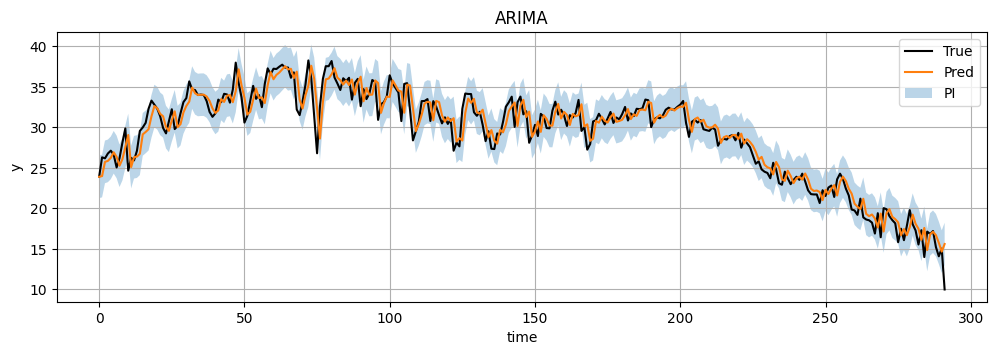

In [7]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= predictions["pred"].to_numpy(),
               PI_low = predictions["lower_bound"].to_numpy(), PI_hi =  predictions["upper_bound"].to_numpy(), conf_PI_low=None, conf_PI_hi=None,
               x_label="time", y_label="y", title='ARIMA')

In [8]:
df_arima

model_name      RMSE      PICP      PIAW     PINAW       CWC
0      ARIMA  1.606266  0.900685  5.288756  0.187062  0.812926

## Linear regression

Define metrics

In [6]:
df_linear = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [7]:
predictions = []  # to store different predictions

Quantile estimation

(1460, 3)


Text(0.5, 0, 'time')

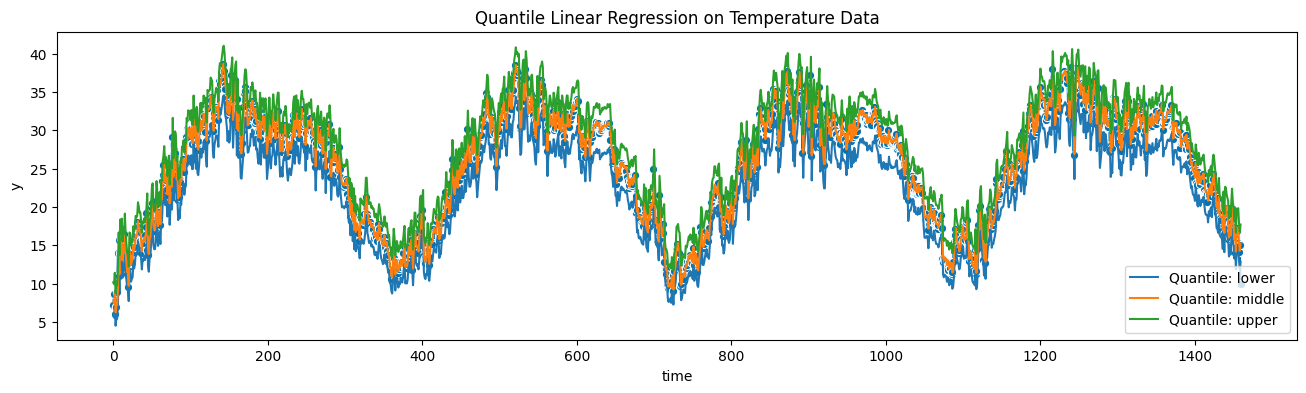

In [8]:
QLR_predictions = {}
        
# fit each prompted quantile and predict on all samples

QLR = QuantileLinearRegressor(quantiles=quantiles.values(), alpha=0)
QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
        df_train["y"].to_numpy())

y_pred = QLR.predict(df["y_lag"].to_numpy().reshape(-1,1))
print(y_pred.shape)

QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)


QLR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QLR_predictions)
plt.title("Quantile Linear Regression on Temperature Data")
plt.xlabel("time")

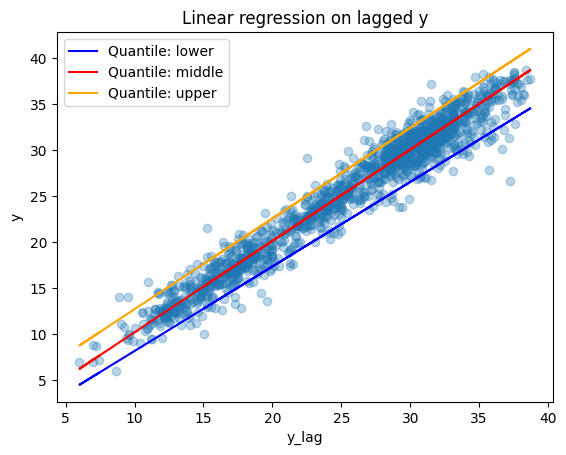

In [9]:
# this cell is to show the correlation between y_lag and y
plt.scatter(df["y_lag"], df["y"], alpha=0.3)
plt.plot(df["y_lag"], QLR_predictions["lower"].flatten(), color="blue",  label="Quantile: lower")

plt.plot(df["y_lag"], QLR_predictions["middle"].flatten(), color="red", label="Quantile: middle")
plt.plot(df["y_lag"], QLR_predictions["upper"].flatten(), color="orange", label="Quantile: upper")


plt.title("Linear regression on lagged y")
plt.xlabel("y_lag")
plt.ylabel("y")
plt.legend()
plt.show()

CQR

  0%|          | 0/292 [00:00<?, ?it/s]

[16:35:05] WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=50213;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=690818;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

100%|██████████| 292/292 [00:42<00:00,  6.86it/s]


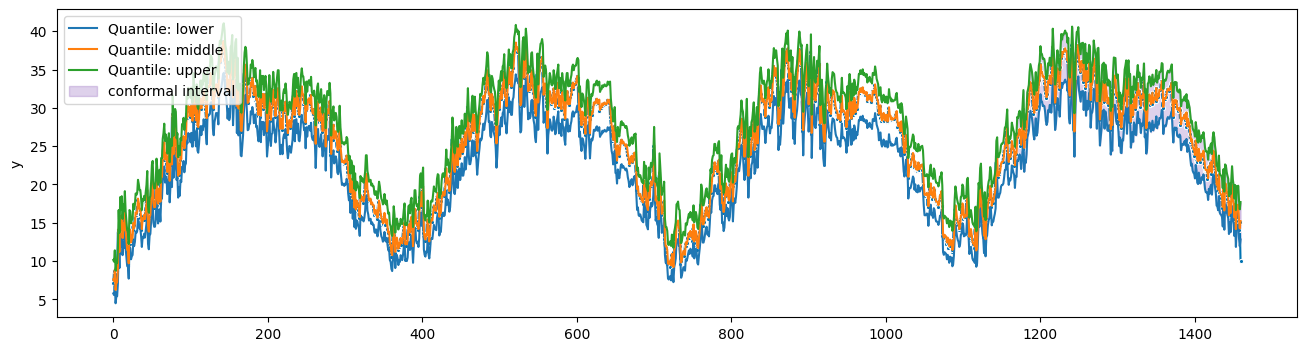

In [10]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[0] = metric.computeAll(model_name="Linear CQR").values()

<Figure size 640x480 with 0 Axes>

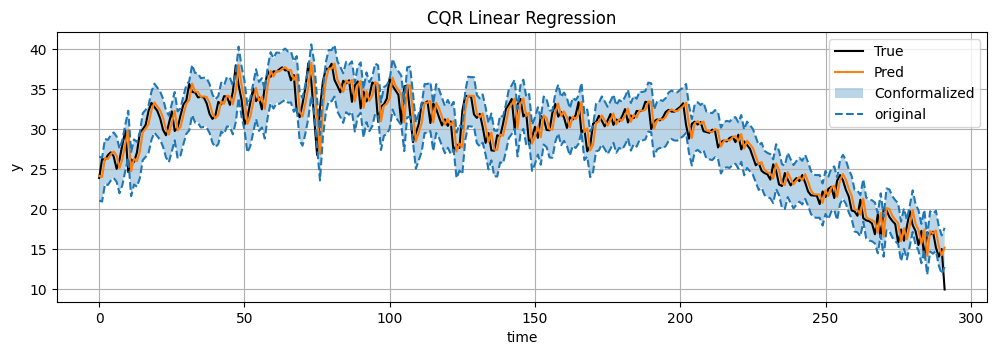

In [11]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Linear Regression')

ACI

100%|██████████| 292/292 [00:02<00:00, 121.46it/s]


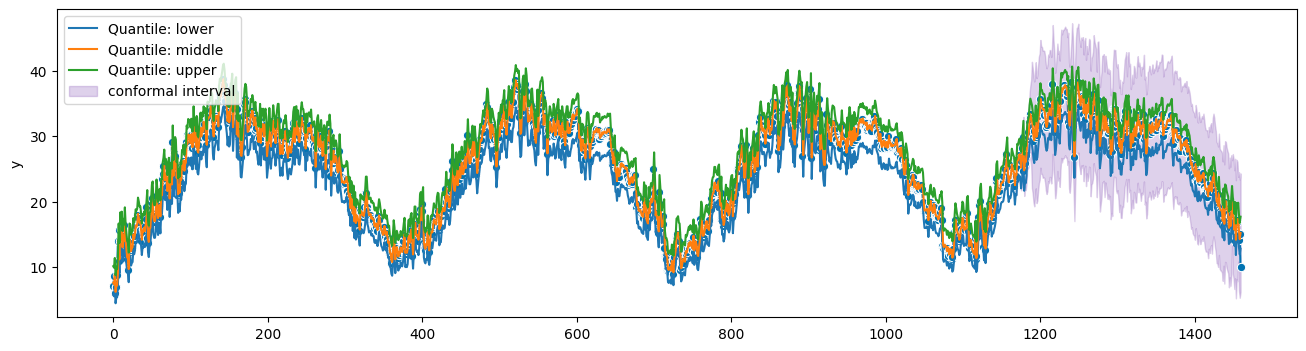

In [12]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[1] = metric.computeAll(model_name="Linear ACI").values()

CQR and ACI plots

<Figure size 640x480 with 0 Axes>

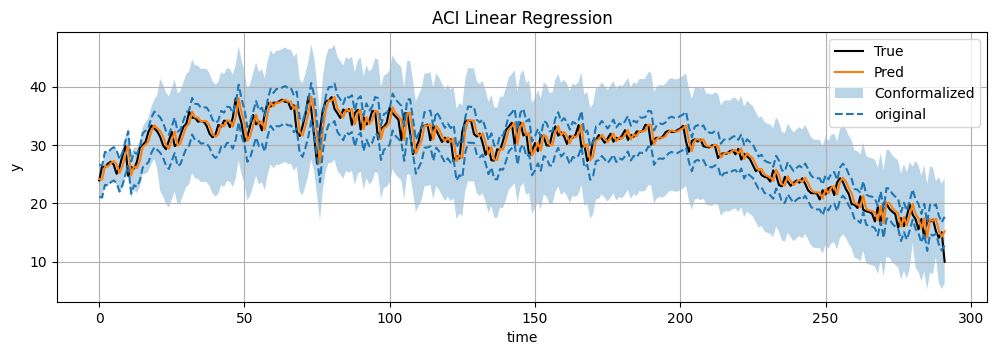

In [13]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Linear Regression')

EnbPI

In [14]:
X_bootstrap = np.concatenate([df_train["y_lag"].to_numpy().reshape(-1,1), 
                              df_val["y_lag"].to_numpy().reshape(-1,1)], axis=0)
X_bootstrap.shape

(1168, 1)

In [15]:
y_bootstrap = np.concatenate([df_train["y"].to_numpy(), df_val["y"].to_numpy()])
y_bootstrap.shape

(1168,)

In [16]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)
bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

batch: 0 batch: 1 batch: 2 batch: 3 batch: 4 batch: 5 batch: 6 batch: 7 batch: 8 batch: 9 batch: 10 batch: 11 batch: 12 batch: 13 batch: 14 batch: 15 batch: 16 batch: 17 batch: 18 batch: 19 

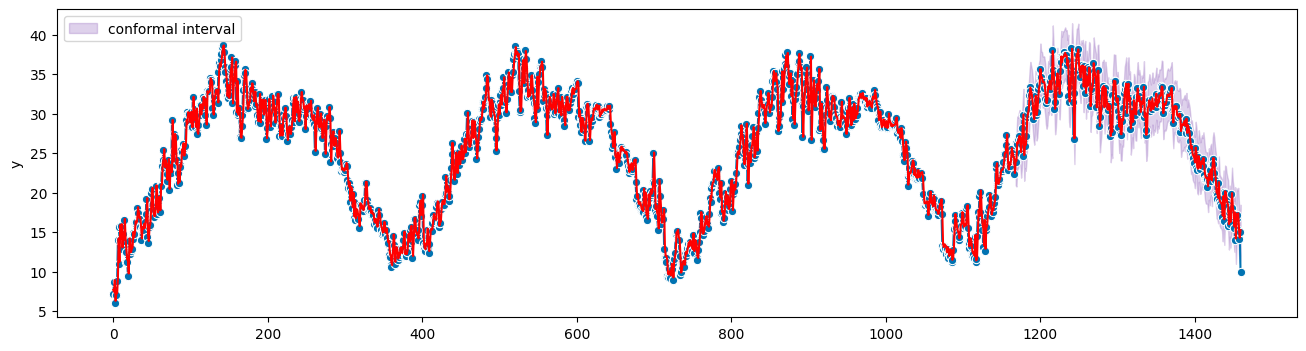

In [17]:
model = QuantileLinearRegressor(quantiles=[0.5], alpha=0)

bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                        bs_train_data=bs_train_data,
                                        X_train=X_bootstrap,
                                        X_test=df_test["y_lag"].to_numpy().reshape(-1,1))

conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=y_bootstrap,
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"]], conformal_intervals[:,0], conformal_intervals[:,1],)
df_linear.loc[2] = metric.computeAll(model_name="Linear EnbPI").values()

In [18]:
df_linear

model_name      RMSE      PICP       PIAW     PINAW       CWC
0    Linear CQR  1.686359  0.904110   5.781332  0.204484  0.795113
1    Linear ACI  1.686359  0.996575  18.176550  0.642900  0.269943
2  Linear EnbPI  1.681509  0.928082   6.535660  0.231165  0.750859

<Figure size 640x480 with 0 Axes>

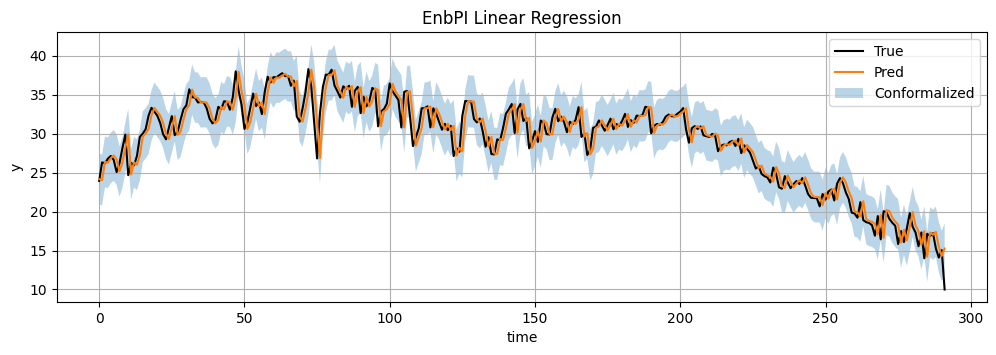

In [19]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Linear Regression')

In [23]:

def local_coverage(y_test, y_lower, y_upper , interval: tuple[int, int]):
    """Compute coverage for a specified interval."""
    l, r = interval
    not_covered = ~((y_test[l:r] >= y_lower[l:r]) & (y_test[l:r] <= y_upper[l:r]))

    return 1 - np.mean(not_covered)


local_coverage(df_test["y"].to_numpy(), conformal_intervals[:,0], conformal_intervals[:,1], (0,200))

0.9299999999999999

In [24]:
len(df)

1460

In [25]:
# we have a test set of 600 samples, so we use a local window of 20 samples
covs = []
for i in range(10, 600):
    cov = local_coverage(df_test["y"].to_numpy(), conformal_intervals[:,0], conformal_intervals[:,1], (i-10,i))
    covs.append(cov)

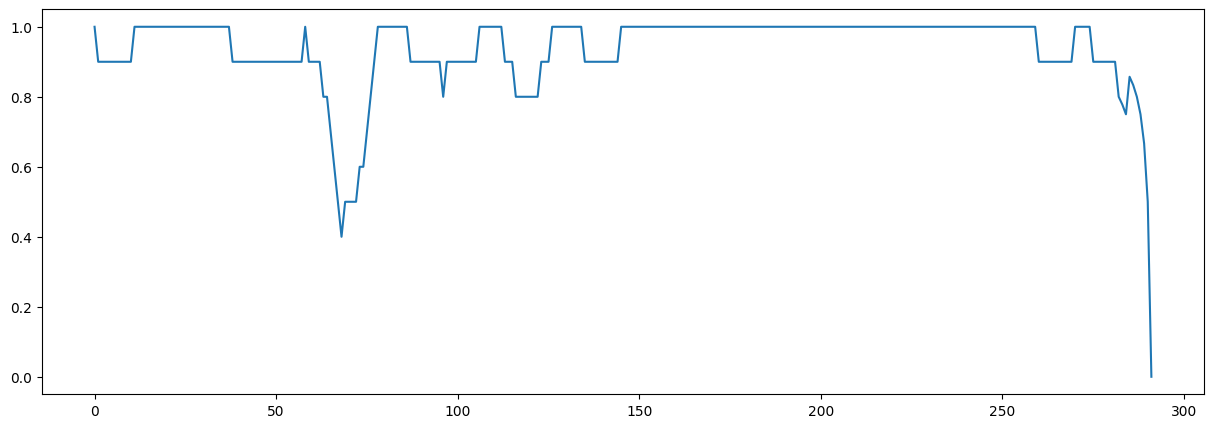

nan


In [26]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(covs)
# create dashed mean plot
ax.plot([0, len(covs)], [np.mean(covs), np.mean(covs)], linestyle="--", color="red")
plt.show()
print(np.mean(covs))

EnCQR

In [20]:
encqr = EnCQR(n_ensembles=3, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test)


In [21]:
model = QuantileLinearRegressor(quantiles=[0.05, 0.5, 0.95], alpha=0)
epsilon_low, epsilon_hi = encqr.train(df_train, train_label, model=model,
                                        train_data=train_data)


Training model for Sb: 0 Training model for Sb: 1 Training model for Sb: 2 

In [22]:
test_label = df_test["y"].to_numpy()

In [23]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label)

Creating test predictions for Sb 0
Creating test predictions for Sb 1
Creating test predictions for Sb 2


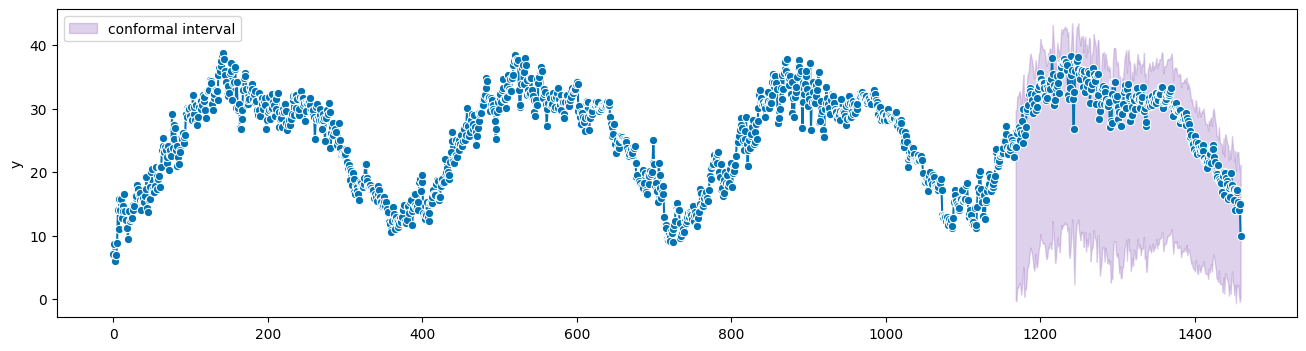

In [24]:

encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_linear.loc[3] = metric.computeAll(model_name="Linear EnCQR").values()

<Figure size 640x480 with 0 Axes>

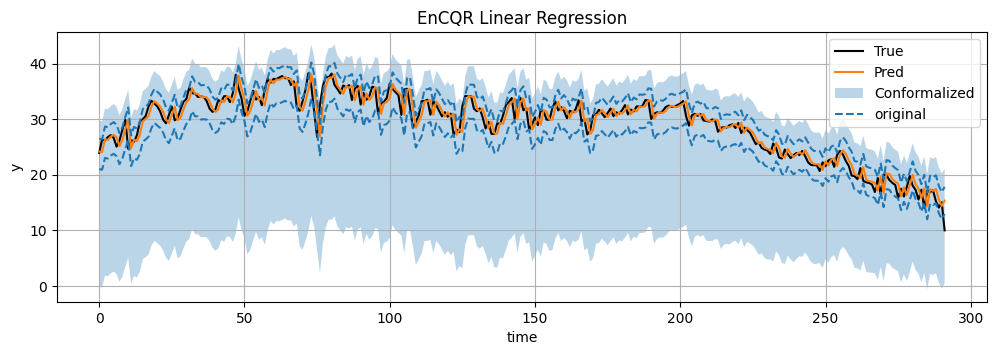

In [25]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Linear Regression')

In [26]:
df_linear

model_name      RMSE      PICP       PIAW     PINAW       CWC
0    Linear CQR  1.686359  0.904110   5.781332  0.204484  0.795113
1    Linear ACI  1.686359  0.996575  18.176550  0.642900  0.269943
2  Linear EnbPI  1.681509  0.928082   6.535660  0.231165  0.750859
3  Linear EnCQR  1.679520  0.996575  28.072840  0.992930  0.005344

Plot testing

In [34]:
def local_cov(y_test, y_lower, y_upper):
    not_covered = ~((y_test >= y_lower) & (y_test <= y_upper))
    
    return 1 - np.mean(not_covered)


local_cov(df_test["y"].to_numpy(), conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten())

0.6164383561643836

## Quantile Forest

Define metrics

In [35]:
df_forest = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [36]:
predictions = []

Quantile estimation

In [37]:
X_all, y_all = df["y_diff_lag"].to_numpy().reshape(-1,1), df["y_diff"].to_numpy()
X_train, y_train = df_train["y_diff_lag"].to_numpy().reshape(-1,1), df_train["y_diff"].to_numpy()
X_val, y_val = df_val["y_diff_lag"].to_numpy().reshape(-1,1), df_val["y_diff"].to_numpy()
X_test, y_test = df_test["y_diff_lag"].to_numpy().reshape(-1,1), df_test["y_diff"].to_numpy()

In [38]:
QFR = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2, differencing=False)
QFR.fit(X_train, y_train)

In [39]:
y_pred = QFR.predict(X_all)
QFR_predictions = {}

1460it [00:08, 172.04it/s]


In [40]:
y_pred.shape

(1460, 3)

In [41]:
QFR_predictions["lower"] = y_pred[:, 0].reshape(1, -1, 1)
QFR_predictions["middle"] = y_pred[:, 1].reshape(1, -1, 1)
QFR_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)

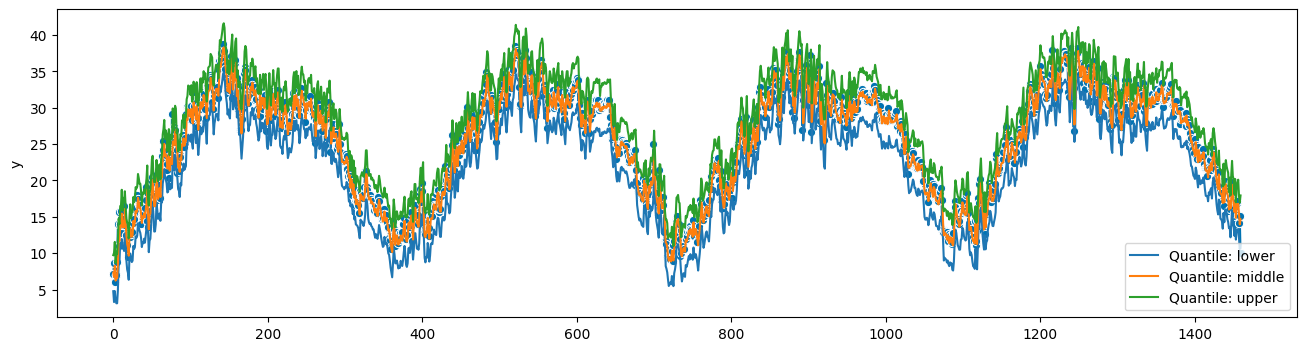

In [42]:
QFR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QFR_predictions)

CQR

100%|██████████| 292/292 [00:00<00:00, 682.49it/s]


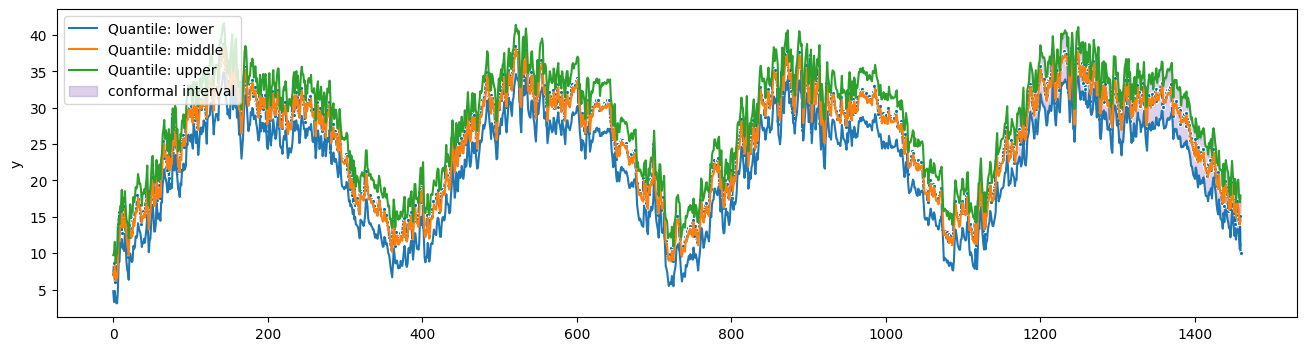

In [43]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[0] = metric.computeAll(model_name="Forest CQR").values()

<Figure size 640x480 with 0 Axes>

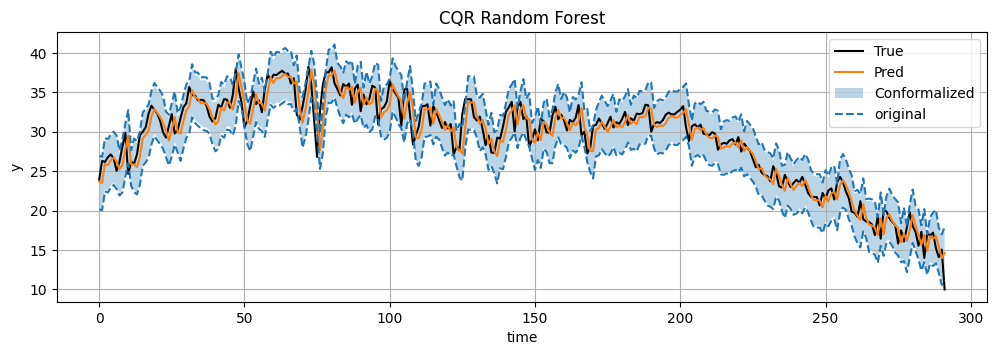

In [44]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Random Forest')

ACI

100%|██████████| 292/292 [00:01<00:00, 263.36it/s]


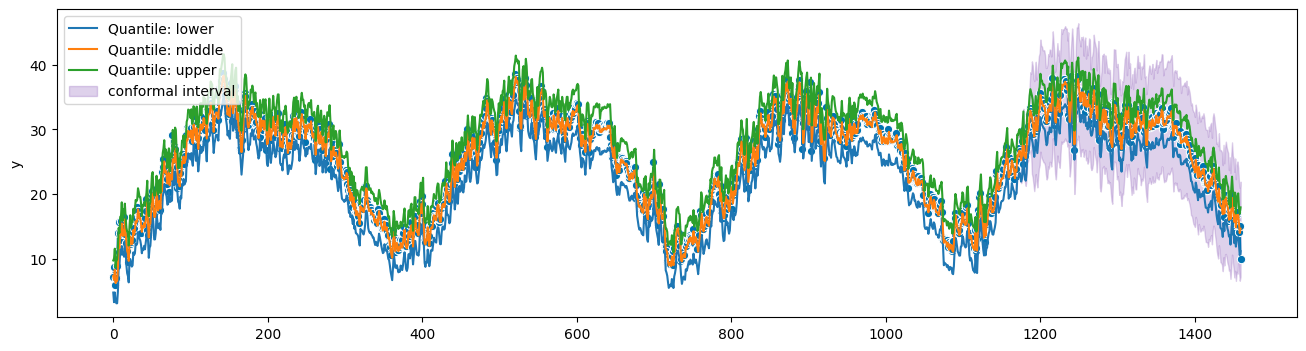

In [45]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[1] = metric.computeAll(model_name="Forest ACI").values()

<Figure size 640x480 with 0 Axes>

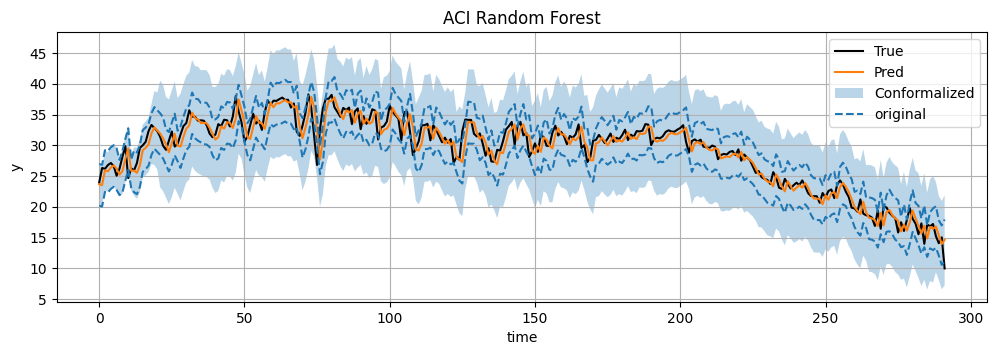

In [46]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Random Forest')

## EnbPI

In [47]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)

X_bootstrap = np.concatenate([X_train, X_val], axis=0)
y_bootstrap = np.concatenate([y_train, y_val])

# train data is y_diff_lag and y_diff to predict eventually y
bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

In [48]:
model = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.5], max_depth=2, differencing=False)

# we train on y diff lag and predict on X bootstrap and X test (both diff lag)
bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                            bs_train_data=bs_train_data,
                                            X_train=np.array(X_bootstrap),
                                            X_test=X_test)

batch: 0 

1460it [00:08, 171.14it/s]


batch: 1 

1460it [00:08, 168.26it/s]


batch: 2 

1460it [00:08, 170.36it/s]


batch: 3 

1460it [00:08, 173.90it/s]


batch: 4 

1460it [00:08, 173.43it/s]


batch: 5 

1460it [00:08, 170.82it/s]


batch: 6 

1460it [00:08, 174.61it/s]


batch: 7 

1460it [00:08, 171.49it/s]


batch: 8 

1460it [00:08, 172.93it/s]


batch: 9 

1460it [00:08, 169.59it/s]


batch: 10 

1460it [00:08, 171.74it/s]


batch: 11 

1460it [00:08, 170.18it/s]


batch: 12 

1460it [00:08, 170.80it/s]


batch: 13 

1460it [00:08, 169.70it/s]


batch: 14 

1460it [00:08, 173.19it/s]


batch: 15 

1460it [00:08, 171.77it/s]


batch: 16 

1460it [00:08, 166.36it/s]


batch: 17 

1460it [00:09, 149.18it/s]


batch: 18 

1460it [00:08, 171.22it/s]


batch: 19 

1460it [00:08, 172.79it/s]


In [49]:
df_train_val = pd.concat([df_train, df_val], axis=0)

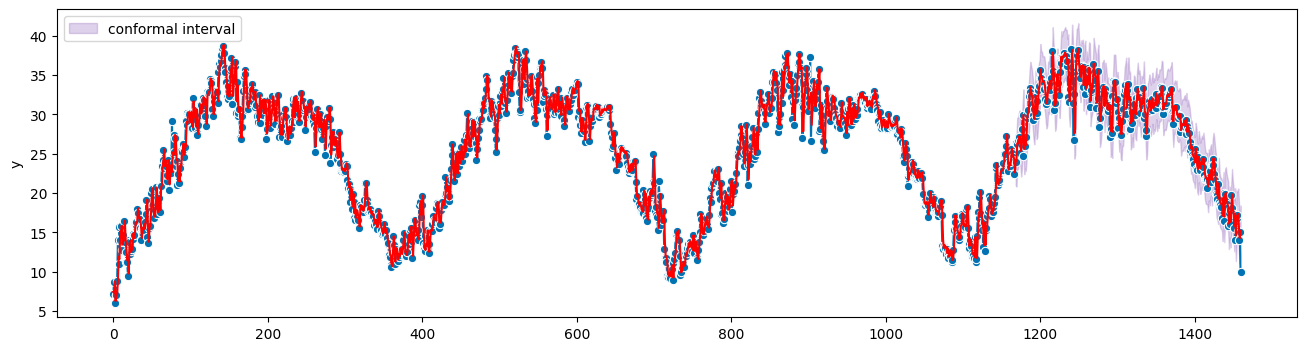

In [50]:

# based on the diff lag predictions and actual
conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=df_train_val["y"].to_numpy(),
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"].to_numpy()], conformal_intervals[:,0], conformal_intervals[:,1],)
df_forest.loc[2] = metric.computeAll(model_name="Forest EnbPI").values()

<Figure size 640x480 with 0 Axes>

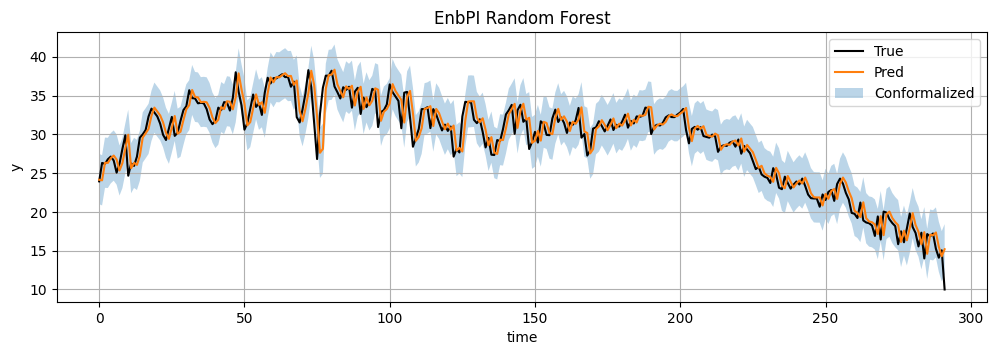

In [51]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Random Forest')

EnCQR

In [52]:
df_train

t          y      y_lag    y_diff  y_diff_lag
0      0   7.166667   7.400000 -0.233333   -2.600000
1      1   8.666667   7.166667  1.500000   -0.233333
2      2   6.000000   8.666667 -2.666667    1.500000
3      3   7.000000   6.000000  1.000000   -2.666667
4      4   7.000000   7.000000  0.000000    1.000000
..   ...        ...        ...       ...         ...
871  871  36.000000  37.375000 -1.375000    1.125000
872  872  37.750000  36.000000  1.750000   -1.375000
873  873  35.250000  37.750000 -2.500000    1.750000
874  874  33.750000  35.250000 -1.500000   -2.500000
875  875  34.750000  33.750000  1.000000   -1.500000

[876 rows x 5 columns]

In [53]:
encqr = EnCQR(n_ensembles=3, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test, differencing=True)


In [54]:
model = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2, differencing=False)

epsilon_low, epsilon_hi = encqr.train(df_train, train_label=train_label, model=model,
                                        train_data=train_data)


Training model for Sb: 0 

389it [00:02, 170.71it/s]
389it [00:02, 170.29it/s]


Training model for Sb: 1 

389it [00:02, 167.10it/s]
389it [00:02, 169.50it/s]


Training model for Sb: 2 

389it [00:02, 170.57it/s]
389it [00:02, 170.86it/s]


In [55]:
test_y.shape

(292,)

In [56]:
test_x.shape

(292, 1)

In [57]:
test_start = len(df_train) + len(df_val)
test_start

1168

In [58]:
test_label = df_test["y"].to_numpy()

In [59]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label, test_start=test_start)

Creating test predictions for Sb 0


292it [00:01, 166.98it/s]


Creating test predictions for Sb 1


292it [00:01, 172.24it/s]


Creating test predictions for Sb 2


292it [00:01, 168.88it/s]


<Figure size 640x480 with 0 Axes>

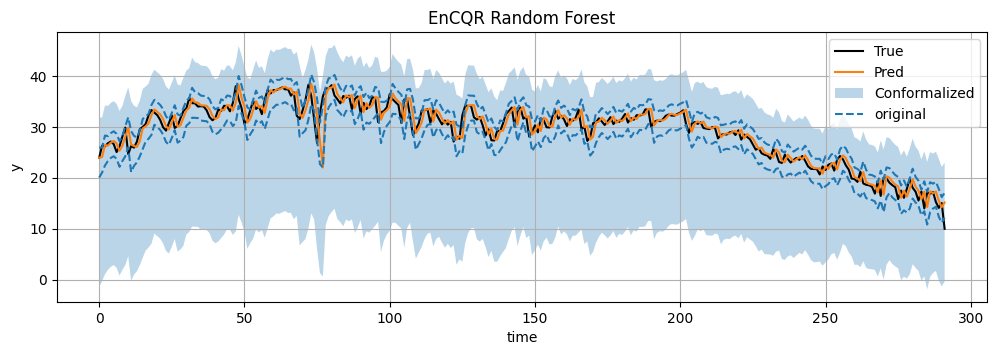

In [60]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Random Forest')

<Figure size 640x480 with 0 Axes>

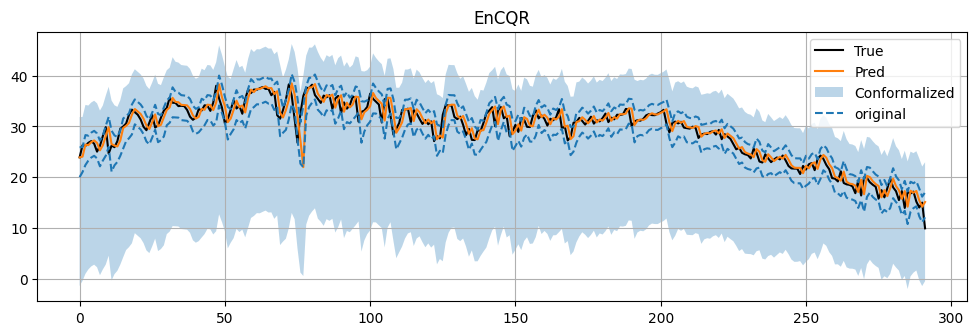

In [61]:
# Plot original and conformalized PI
encqr.plot_PIs(df_test["y"].to_numpy(), PI[:,:,1],
               PI[:,:,0], PI[:,:,2],
               conf_PI[:,:,0], conf_PI[:,:,2], title='EnCQR')

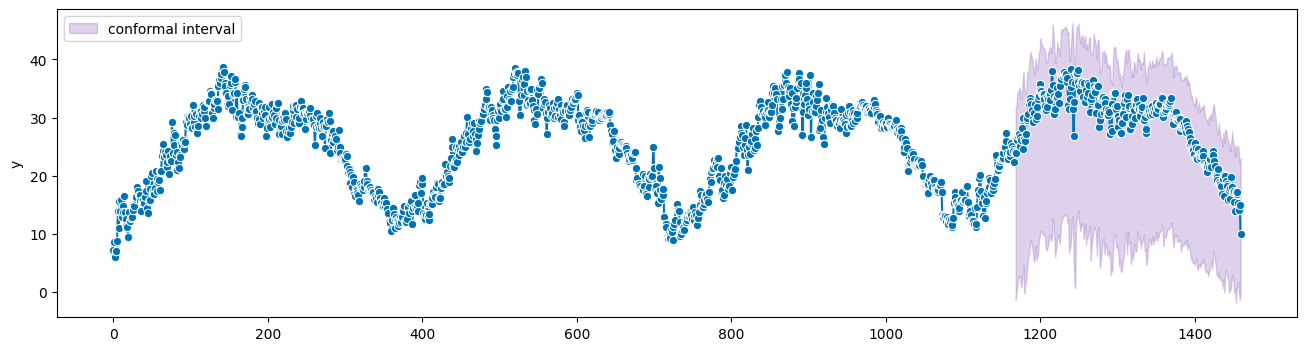

In [62]:
encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_forest.loc[3] = metric.computeAll(model_name="Forest EnCQR").values()

In [63]:
df_forest

model_name      RMSE      PICP       PIAW     PINAW       CWC
0    Forest CQR  1.679890  0.900685   5.929182  0.209714  0.790275
1    Forest ACI  1.679890  0.996575  16.280022  0.575821  0.320651
2  Forest EnbPI  1.727872  0.924658   6.507074  0.230154  0.755932
3  Forest EnCQR  1.860720  1.000000  30.294624  1.071514 -0.052979

## Neural Regression with QRNN

Define metrics

In [64]:
df_NN = pd.DataFrame({"model_name" : [],
                      "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [65]:
predictions = []

In [66]:
quantiles

{'lower': 0.05, 'middle': 0.5, 'upper': 0.95}

Quantile estimation

In [67]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)

In [68]:
logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        10.847        
      2   0.0005         5.596        
      3   0.0005         1.486        
      4   0.0005         1.453        
      5   0.0005         1.281        
      6   0.0005         0.909        
      7   0.0005         0.717        
      8   0.0005         0.564        
      9   0.0005         0.436        
     10   0.0005         0.368        
     11   0.0005         0.368        
     12   0.0005         0.354        
     13   0.0005         0.365        
     14   0.0005         0.347        
     15   0.0005         0.343

In [69]:

y_pred = qrnn.predict(df["y_lag"].values.reshape(-1,1))

NN_predictions = {}
NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)


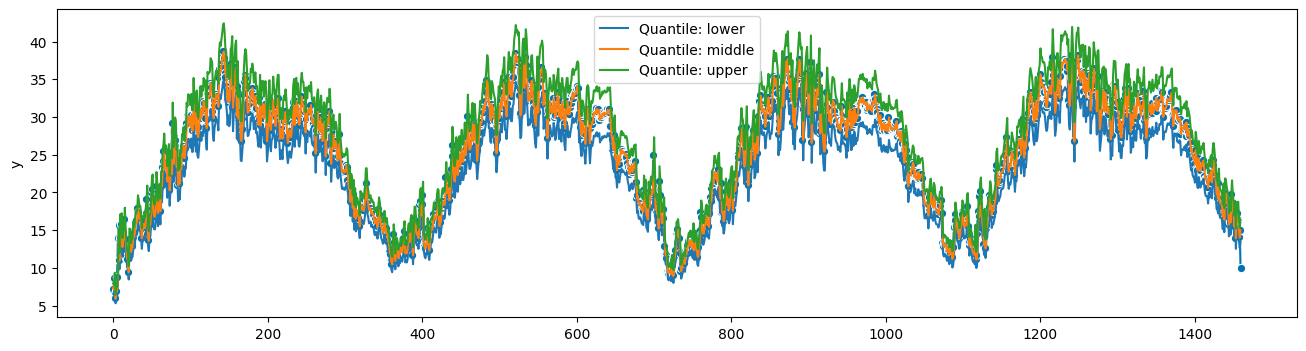

In [70]:
qrnn.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions)

CQR

100%|██████████| 292/292 [00:00<00:00, 670.29it/s]


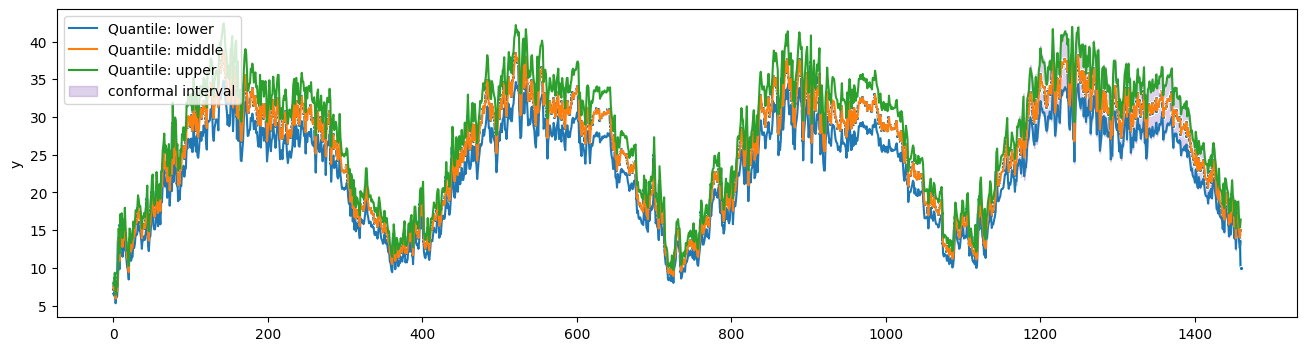

In [71]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[0] = metric.computeAll(model_name="NN CQR").values()

<Figure size 640x480 with 0 Axes>

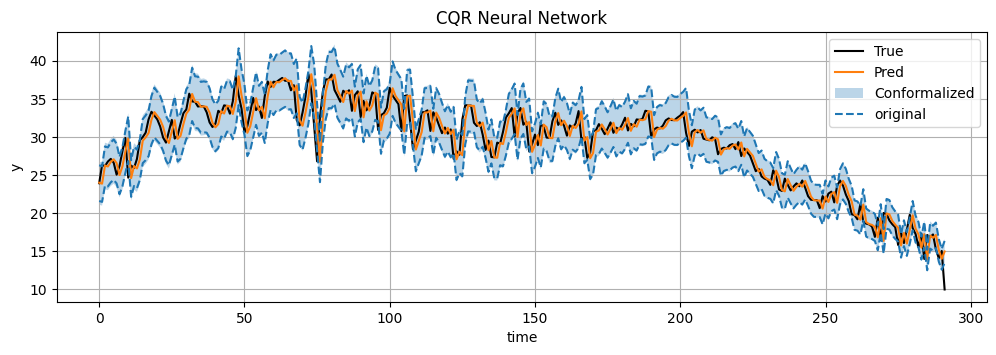

In [72]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Neural Network')

ACI

100%|██████████| 292/292 [00:01<00:00, 272.82it/s]


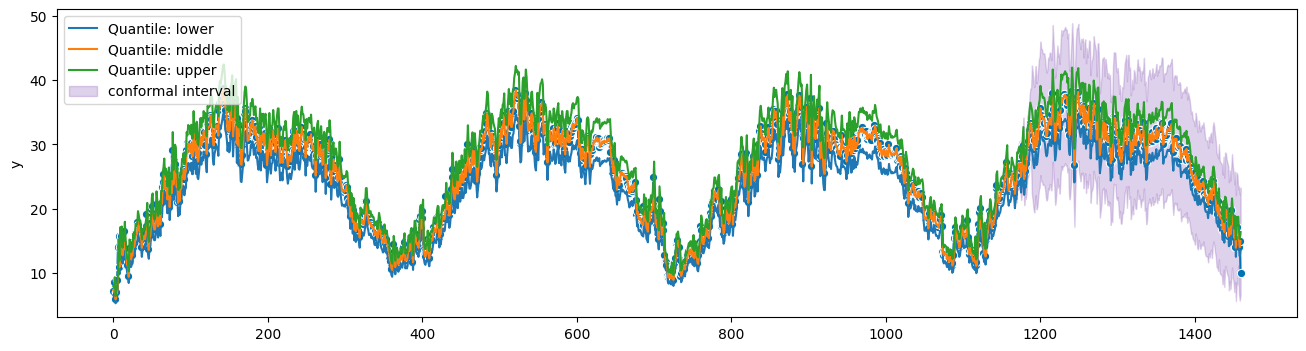

In [73]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[1] = metric.computeAll(model_name="NN ACI").values()

<Figure size 640x480 with 0 Axes>

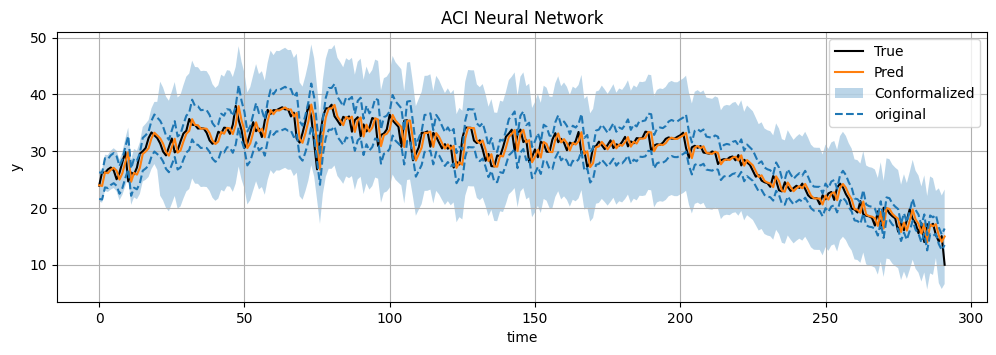

In [74]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Neural Network')

EnbPI

In [75]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=[0.5], n_inputs=1, model_params=model)

In [76]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)

X_bootstrap = np.concatenate([df_train["y_lag"].to_numpy().reshape(-1,1), df_val["y_lag"].to_numpy().reshape(-1,1)], axis=0)
y_bootstrap = np.concatenate([df_train["y"].to_numpy(), df_val["y"].to_numpy()])

bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

In [77]:
batch = pd.DataFrame({"y_lag" : bs_train_data[0][0][:,0], "y": bs_train_data[0][1].flatten()})

In [78]:
from IPython.utils import io

In [79]:
model = qrnn

# this is to hide the training logs
with io.capture_output() as captured:
    bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                            bs_train_data=bs_train_data,
                                            X_train=np.array(X_bootstrap),
                                            X_test=df_test["y_lag"].to_numpy().reshape(-1,1))

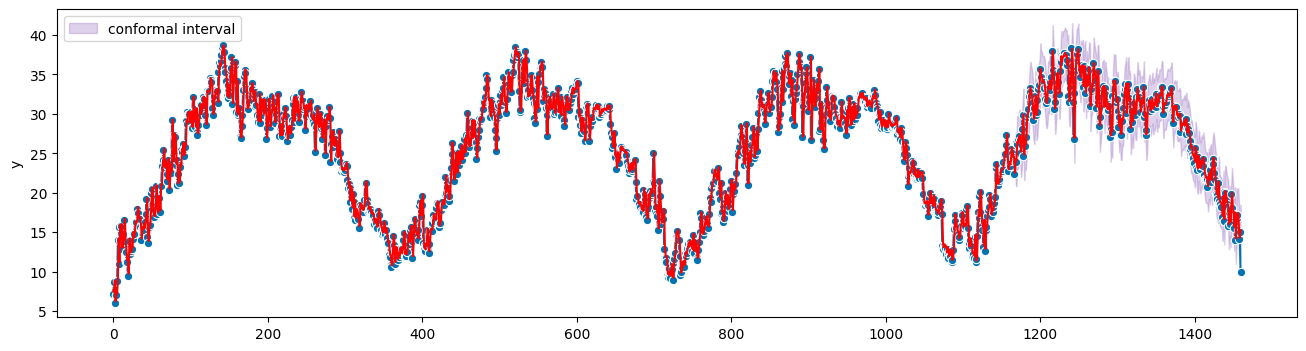

In [80]:
conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=y_bootstrap,
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"].to_numpy()], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[2] = metric.computeAll(model_name="NN EnbPI").values()

<Figure size 640x480 with 0 Axes>

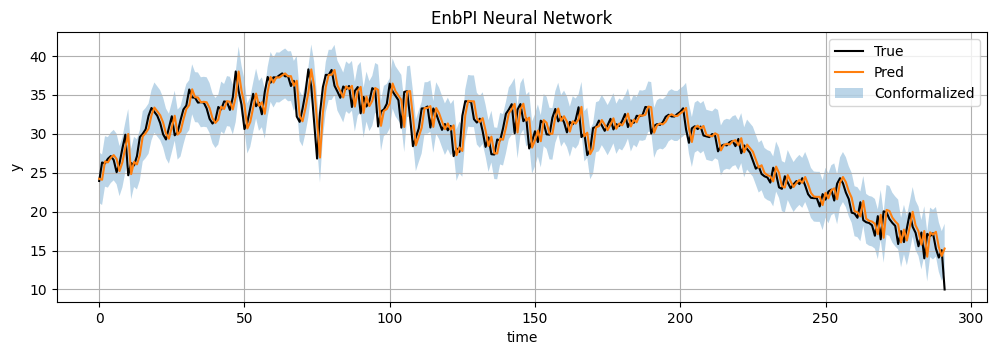

In [81]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Neural Network')

EnCQR

In [82]:
encqr = EnCQR(n_ensembles=8, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test)


In [83]:
layers = 2
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=[0.05, 0.5, 0.95], n_inputs=1, model_params=model)

In [84]:
model = qrnn
epsilon_low, epsilon_hi = encqr.train(df_train, train_label=train_label, model=model,
                                        train_data=train_data)


Output()

Training model for Sb: 0 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        11.591        
      2   0.0005        11.209        
      3   0.0005        10.621        
      4   0.0005        10.384        
      5   0.0005        10.164        
      6   0.0005         9.481        
      7   0.0005         9.306        
      8   0.0005         9.281        
      9   0.0005         8.703        
     10   0.0005         8.273        
     11   0.0005         7.954        
     12   0.0005         7.518        
     13   0.0005         7.236        
     14   0.0005         6.969        
     15   0.0005         6.594

Output()

Training model for Sb: 1 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         8.173        
      2   0.0005         7.761        
      3   0.0005         7.252        
      4   0.0005         6.848        
      5   0.0005         6.333        
      6   0.0005         5.851        
      7   0.0005         5.390        
      8   0.0005         4.884        
      9   0.0005         4.416        
     10   0.0005         3.921        
     11   0.0005         3.421        
     12   0.0005         2.995        
     13   0.0005         2.465        
     14   0.0005         2.023        
     15   0.0005         1.707

Output()

Training model for Sb: 2 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         0.821        
      2   0.0005         0.689        
      3   0.0005         0.562        
      4   0.0005         0.437        
      5   0.0005         0.372        
      6   0.0005         0.360        
      7   0.0005         0.374        
      8   0.0005         0.401        
      9   0.0005         0.420        
     10   0.0005         0.431        
     11   0.0005         0.418        
     12   0.0005         0.400        
     13   0.0005         0.380        
     14   0.0005         0.334        
     15   0.0005         0.325

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         0.466        
      2   0.0005         0.454        
      3   0.0005         0.415        
      4   0.0005         0.428        
      5   0.0005         0.422        
      6   0.0005         0.403        
      7   0.0005         0.380        
      8   0.0005         0.361        
      9   0.0005         0.364        
     10   0.0005         0.361        
     11   0.0005         0.367        
     12   0.0005         0.367        
     13   0.0005         0.362        
     14   0.0005         0.358        
     15   0.0005         0.377

Output()

Training model for Sb: 4 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         0.303        
      2   0.0005         0.359        
      3   0.0005         0.289        
      4   0.0005         0.310        
      5   0.0005         0.333        
      6   0.0005         0.311        
      7   0.0005         0.279        
      8   0.0005         0.301        
      9   0.0005         0.308        
     10   0.0005         0.308        
     11   0.0005         0.290        
     12   0.0005         0.306        
     13   0.0005         0.294        
     14   0.0005         0.301        
     15   0.0005         0.287

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         0.330        
      2   0.0005         0.341        
      3   0.0005         0.321        
      4   0.0005         0.312        
      5   0.0005         0.318        
      6   0.0005         0.316        
      7   0.0005         0.320        
      8   0.0005         0.316        
      9   0.0005         0.320        
     10   0.0005         0.313        
     11   0.0005         0.309        
     12   0.0005         0.322        
     13   0.0005         0.317        
     14   0.0005         0.311        
     15   0.0005         0.311

Output()

Training model for Sb: 6 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         0.353        
      2   0.0005         0.377        
      3   0.0005         0.350        
      4   0.0005         0.396        
      5   0.0005         0.387        
      6   0.0005         0.375        
      7   0.0005         0.388        
      8   0.0005         0.346        
      9   0.0005         0.387        
     10   0.0005         0.336        
     11   0.0005         0.364        
     12   0.0005         0.354        
     13   0.0005         0.389        
     14   0.0005         0.373        
     15   0.0005         0.389

Output()

Training model for Sb: 7 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         0.295        
      2   0.0005         0.300        
      3   0.0005         0.290        
      4   0.0005         0.279        
      5   0.0005         0.292        
      6   0.0005         0.289        
      7   0.0005         0.277        
      8   0.0005         0.280        
      9   0.0005         0.279        
     10   0.0005         0.282        
     11   0.0005         0.290        
     12   0.0005         0.277        
     13   0.0005         0.268        
     14   0.0005         0.283        
     15   0.0005         0.277

In [85]:
test_label = df_test["y"].to_numpy()

In [86]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label)

Creating test predictions for Sb 0
Creating test predictions for Sb 1
Creating test predictions for Sb 2
Creating test predictions for Sb 3
Creating test predictions for Sb 4
Creating test predictions for Sb 5
Creating test predictions for Sb 6
Creating test predictions for Sb 7


In [87]:
conf_PI.shape

(292, 1, 3)

In [88]:
# # Plot original and conformalized PI
# encqr.plot_PIs(test_y, PI[:,:,1],
#                PI[:,:,0], PI[:,:,2],
#                conf_PI[:,:,0], conf_PI[:,:,2], title='EnCQR')

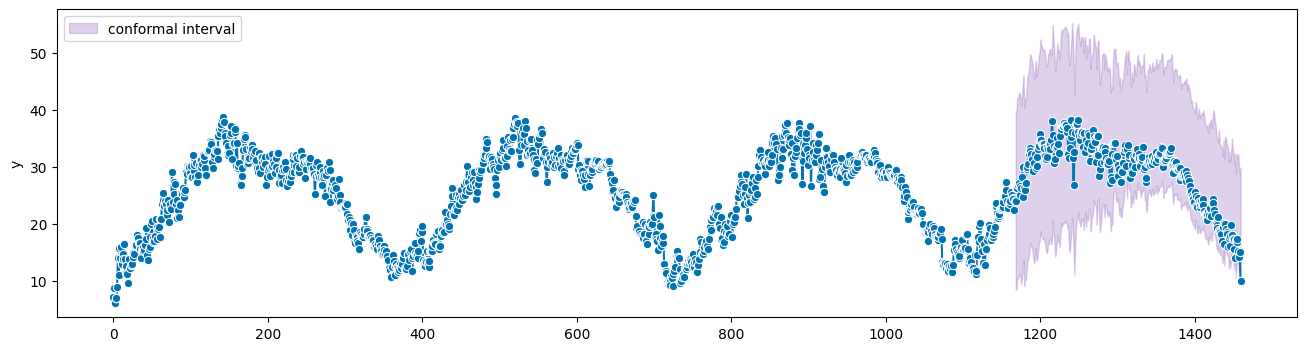

In [89]:
encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_NN.loc[3] = metric.computeAll(model_name="NN EnCQR").values()

<Figure size 640x480 with 0 Axes>

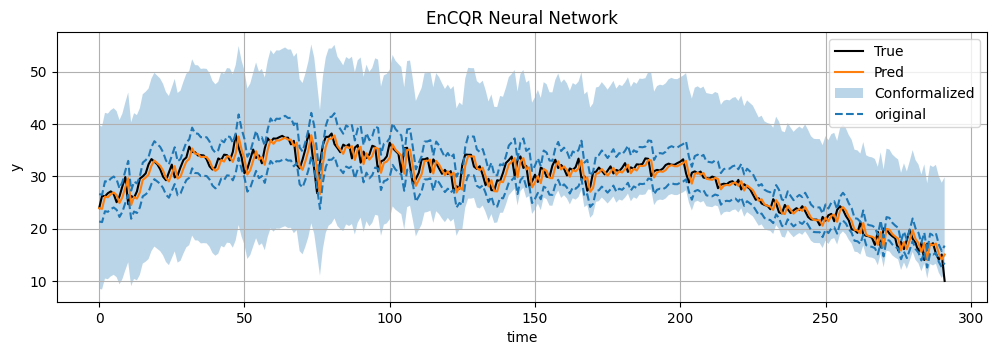

In [90]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Neural Network')

In [91]:
df_NN

model_name      RMSE      PICP       PIAW     PINAW       CWC
0     NN CQR  1.684749  0.907534   6.209660  0.219634  0.779038
1     NN ACI  1.684749  0.996575  18.689835  0.661055  0.256219
2   NN EnbPI  1.684334  0.924658   6.461947  0.228558  0.757499
3   NN EnCQR  1.688565  0.996575  25.517964  0.902565  0.073654

# Comparison

## Tables

In [92]:
df_arima.to_csv(f"{dataset}_arima_100_2.csv")
df_arima

model_name      RMSE      PICP      PIAW     PINAW       CWC
0      ARIMA  1.606266  0.900685  5.288756  0.187062  0.812926

In [27]:
df_linear.to_csv(f"{dataset}_linear_100_2.csv")

In [94]:
df_forest.to_csv(f"{dataset}_forest_100_2.csv")

In [95]:
df_NN.to_csv(f"{dataset}_NN_100_3.csv")

GRID SEARCH

In [96]:
# scores_lin, gamma_lin = optimize_conformal(model_predictions=QLR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [97]:
# scores_rf, gamma_rf = optimize_conformal(model_predictions=QFR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [98]:
# scores_nn, gamma_nn = optimize_conformal(model_predictions=NN_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)